In [60]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from scipy.stats import f_oneway, kruskal

In [56]:
train_ds = pd.read_csv('train.csv')
train_ds.drop(columns=['id'], inplace=True)
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                 

### Data Preperation

In [28]:
n, m = train_ds.shape

target = train_ds[['Target']]
X = train_ds.drop(columns=['Target'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(target)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

c:\Users\benbr\Documents\code\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Distribution of Values

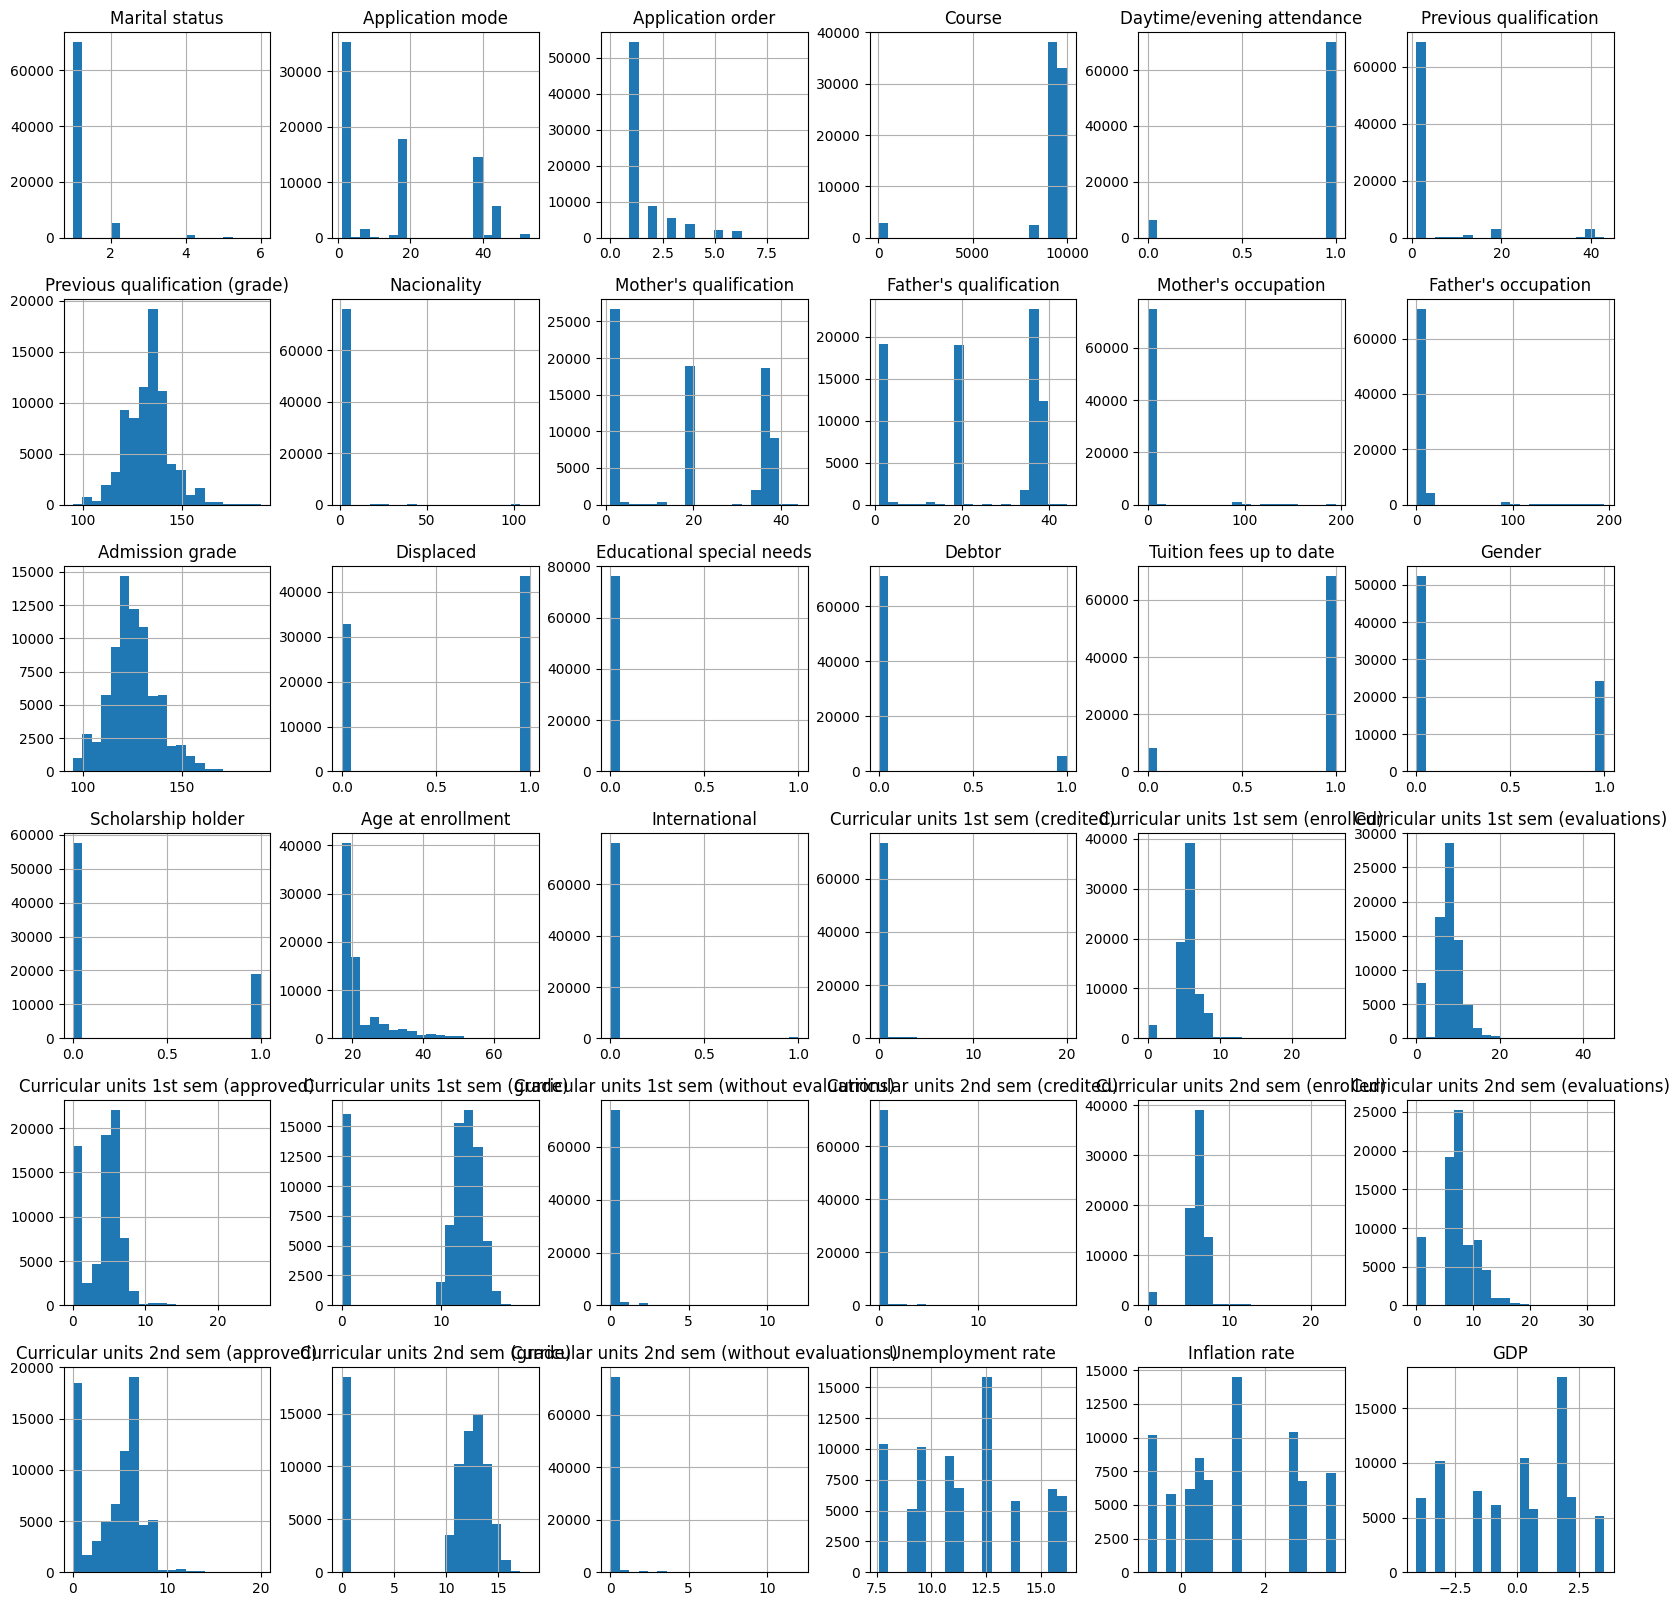

In [13]:
X.hist(figsize=(20, 20), bins=20);

### Correlation Map

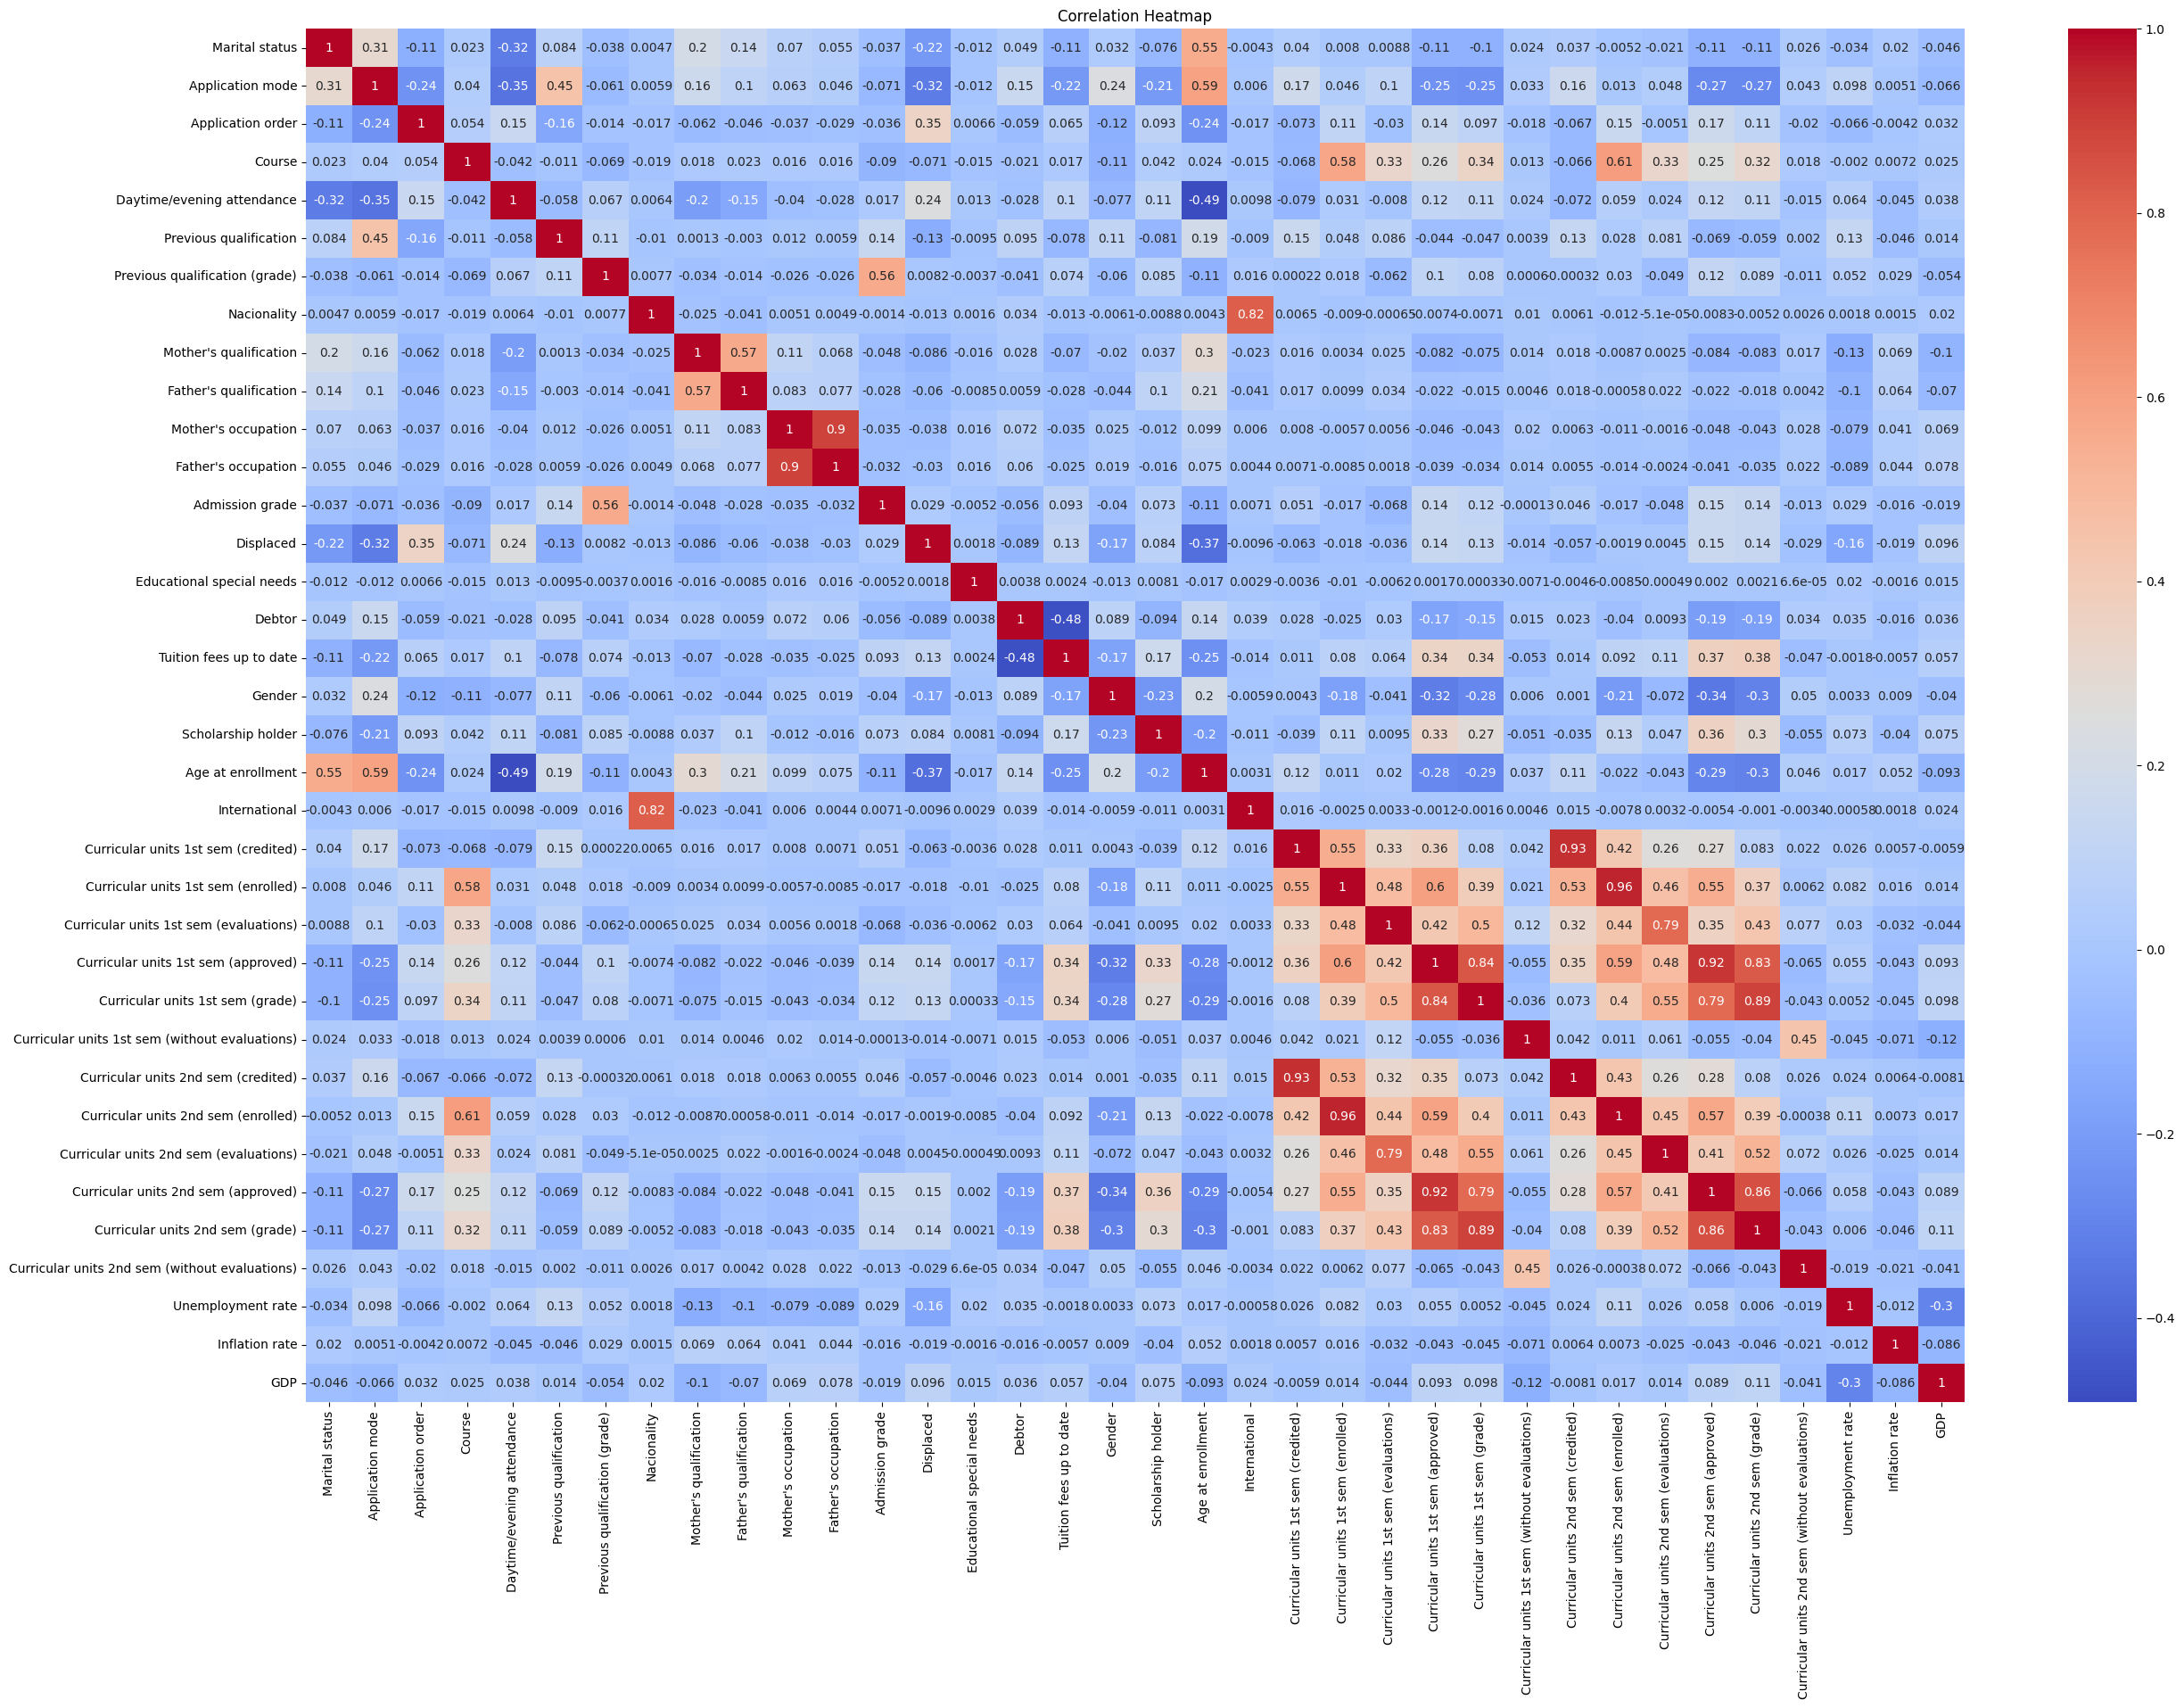

In [20]:
plt.figure(figsize=(30, 20))
sns.heatmap(pd.DataFrame(X_scaled, columns=X.columns).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Distribution of Target Variable

C:\Users\benbr\AppData\Local\Temp\ipykernel_23780\380297590.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=target, palette='viridis')


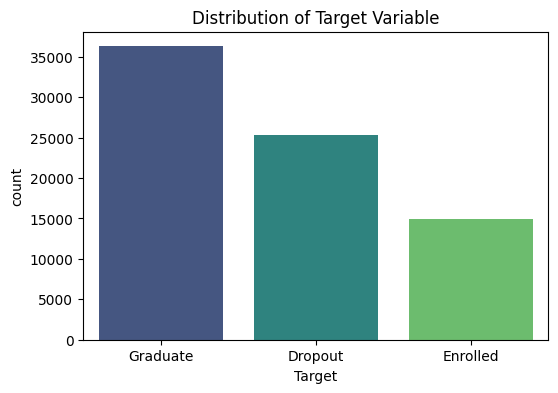

In [36]:
# Distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=target, palette='viridis')
plt.title('Distribution of Target Variable')
plt.show()

### Baseline model

In [77]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the XGBoost classifier with hyperparameter tuning
param_grid = {
    'n_estimators': [200],
    'max_depth': [3],
    'learning_rate': [0.2]
}
base_line_model = XGBClassifier(use_label_encoder=False, 
                        eval_metric='logloss',
                        seed=0)

grid_search = GridSearchCV(estimator=base_line_model,
                            param_grid=param_grid,
                            cv=3,
                            scoring='accuracy',
                            verbose=1,
                            n_jobs=-1)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\benbr\Documents\code\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2], 'max_depth': [3],
                         'n_estimators': [200]},
             scoring='accuracy', verbose=1)

### Evaluate the baseline model

In [78]:
base_line_model = grid_search.best_estimator_
base_line_model.fit(X_train, y_train)

y_pred = base_line_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, base_line_model.predict_proba(X_test), multi_class='ovr')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'ROC AUC Score: {roc_auc:.2f}')

c:\Users\benbr\Documents\code\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 83.26%
ROC AUC Score: 0.94


In [81]:
feature_importances = pd.DataFrame(base_line_model.feature_importances_,
                                    index=X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                                                importance
Curricular units 2nd sem (approved)               0.491856
Tuition fees up to date                           0.075730
Curricular units 1st sem (approved)               0.058355
Scholarship holder                                0.055662
Curricular units 2nd sem (evaluations)            0.042317
Curricular units 1st sem (evaluations)            0.039202
Curricular units 2nd sem (grade)                  0.026723
Curricular units 2nd sem (enrolled)               0.026433
Debtor                                            0.018407
Gender                                            0.016368
Age at enrollment                                 0.011580
Curricular units 1st sem (enrolled)               0.011341
Curricular units 1st sem (grade)                  0.010954
Daytime/evening attendance                        0.010232
Course                                            0.009425
Application mode                                  0.0092

### Feature Selection

In [74]:
# Null Hypothesis: No difference between the groups.
# Alternative Hypothesis: There is a difference between the groups.

for feature in train_ds.drop(columns=['Target']).columns.tolist():
    groups = [y[train_ds[feature]==category] for category in train_ds[feature].unique()]
    h_val, p_val = f_oneway(*groups)
    print(f'ANOVA test results for {feature}: H-value = {h_val}, P-value = {p_val}')

    h_val, p_val = kruskal(*groups)
    print(f'Kruskal-Wallis test results for {feature}: H-value = {h_val}, P-value = {p_val}\n')

ANOVA test results for Marital status: H-value = 310.9728104282708, P-value = 0.0
Kruskal-Wallis test results for Marital status: H-value = 1462.4992658455972, P-value = 0.0

ANOVA test results for Application mode: H-value = 670.5217409476599, P-value = 0.0
Kruskal-Wallis test results for Application mode: H-value = 11561.260482917714, P-value = 0.0

ANOVA test results for Application order: H-value = 274.01744681482415, P-value = 0.0
Kruskal-Wallis test results for Application order: H-value = 1915.9170908188642, P-value = 0.0

ANOVA test results for Course: H-value = 867.7277325160352, P-value = 0.0
Kruskal-Wallis test results for Course: H-value = 13328.515446309822, P-value = 0.0

ANOVA test results for Daytime/evening attendance: H-value = 1204.3779788227487, P-value = 7.484021951142844e-262
Kruskal-Wallis test results for Daytime/evening attendance: H-value = 1142.1031190300587, P-value = 2.3343544124777647e-250

ANOVA test results for Previous qualification: H-value = 235.89869

In [87]:
# Calculate correlation matrix
corr_matrix = X.corr()

# Convert the correlation matrix to a long format
corr_pairs = corr_matrix.abs().unstack().reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# Remove self-correlations
corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]

# Sort by correlation values
corr_pairs_sorted = corr_pairs.sort_values(by='Correlation', ascending=False).drop_duplicates()

# Print the sorted correlation pairs
print(corr_pairs_sorted.head(25))

                                    Feature1  \
820      Curricular units 1st sem (enrolled)   
1030     Curricular units 2nd sem (enrolled)   
993      Curricular units 2nd sem (credited)   
783      Curricular units 1st sem (credited)   
1104     Curricular units 2nd sem (approved)   
894      Curricular units 1st sem (approved)   
406                      Father's occupation   
371                      Mother's occupation   
931         Curricular units 1st sem (grade)   
1141        Curricular units 2nd sem (grade)   
1111     Curricular units 2nd sem (approved)   
1146        Curricular units 2nd sem (grade)   
889      Curricular units 1st sem (approved)   
924         Curricular units 1st sem (grade)   
1140        Curricular units 2nd sem (grade)   
895      Curricular units 1st sem (approved)   
727                            International   
272                              Nacionality   
930         Curricular units 1st sem (grade)   
1105     Curricular units 2nd sem (appro